
# TP adversarial images
### Diane LINGRAND 

diane.lingrand@univ-cotedazur.fr 

# Introduction
inspired by examples from https://foolbox.readthedocs.io/en/stable/

In [143]:
!pip uninstall foolbox -y
!pip install foolbox==2.4

     |████████████████████████████████| 1.9 MB 3.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for foolbox: filename=foolbox-2.4.0-py3-none-any.whl size=1926223 sha256=8a8d1c6c8b9ac9031f87858ecb435c2a5c2ab88f833f862d6e93c020c9cc699c
  Stored in directory: /home/qlr/.cache/pip/wheels/bb/ed/6f/2ccfabd5fd5d8930134b652822d0c4745eb60678d04bb92ba1
Successfully built foolbox
You should consider upgrading via the '/home/qlr/anaconda3/bin/python -m pip install --upgrade pip' command.


In [144]:
from IPython.display import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import foolbox
import tensorflow as tf
import eagerpy as ep
from foolbox import TensorFlowModel, accuracy, samples, Model
from foolbox.attacks import LinfPGD

# LinfPG attack
Linf PGD stands for Projected Gradient Descent. In this attack, the model is known and will be used for the gradient descent. At each step, a neighborhood ball around the current position is examined (radius corresponding to the maximum amount of perturbation) for searching the minimum loss function value. The projection corresponds to moving the current position to the minimal loss function value position.

In [145]:
# loading the ResNet50 network
model = tf.keras.applications.ResNet50(weights="imagenet")
pre = dict(flip_axis=-1, mean=[104.0, 116.0, 123.0])  # RGB to BGR

fmodel = TensorFlowModel(model, bounds=(0, 255), preprocessing=pre)
fmodel = fmodel.transform_bounds((0, 1))

In [146]:
# computing the accuracy of the ResNet50 network on the imagenet dataset

images, labels = samples(fmodel, dataset="imagenet", batchsize=16)
acc = accuracy(fmodel, images, labels)

print("accuracy:", acc * 100 ,"%")

accuracy: 87.5 %


In [147]:
%%time
#attack definition and computation (launch this box and go for a coffee)
epsilons = [0.001, 0.01, 0.1, 0.5]

attack = LinfPGD()
raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilons)

CPU times: user 15 s, sys: 733 ms, total: 15.8 s
Wall time: 33 s


In [148]:
print(success.numpy())

[[False  True  True False False False  True  True False False False  True
   True False  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]


In [149]:
# calculate and report the robust accuracy (the accuracy of the model when it is attacked)

robust_accuracy = 1 - np.mean(success, axis=-1)

print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  Linf norm ≤ 0.001 : 56.2 %
  Linf norm ≤ 0.01  :  0.0 %
  Linf norm ≤ 0.1   :  0.0 %
  Linf norm ≤ 0.5   :  0.0 %


In [150]:
# we can also manually check this
# we will use the clipped advs instead of the raw advs, otherwise
# we would need to check if the perturbation sizes are actually
# within the specified epsilon bound

print("we can also manually check this:\n")
print("robust accuracy for perturbations with")

for eps, advs_ in zip(epsilons, clipped_advs):
    acc2 = accuracy(fmodel, advs_, labels)
    print(f"  Linf norm ≤ {eps:<6}: {acc2 * 100:4.1f} %")
    perturb = np.linalg.norm(advs_ - images)
    print("    perturbation sizes:", perturb)
    if acc2 == 0:
        break

we can also manually check this:

robust accuracy for perturbations with
  Linf norm ≤ 0.001 : 56.2 %
    perturbation sizes: 1.2884829
  Linf norm ≤ 0.01  :  0.0 %
    perturbation sizes: 10.312013


In [151]:
print(images.shape)
print(type(images))
print(type(images.numpy()))

(16, 224, 224, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>


In [152]:
img = advs_[0].numpy()
l = np.array([img])
print(l.shape)
print(np.argmax(model.predict(l)))

(1, 224, 224, 3)
111


In [153]:
print(type(labels.numpy()))
print(labels.numpy()[0])

<class 'numpy.ndarray'>
243


original label: 915


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


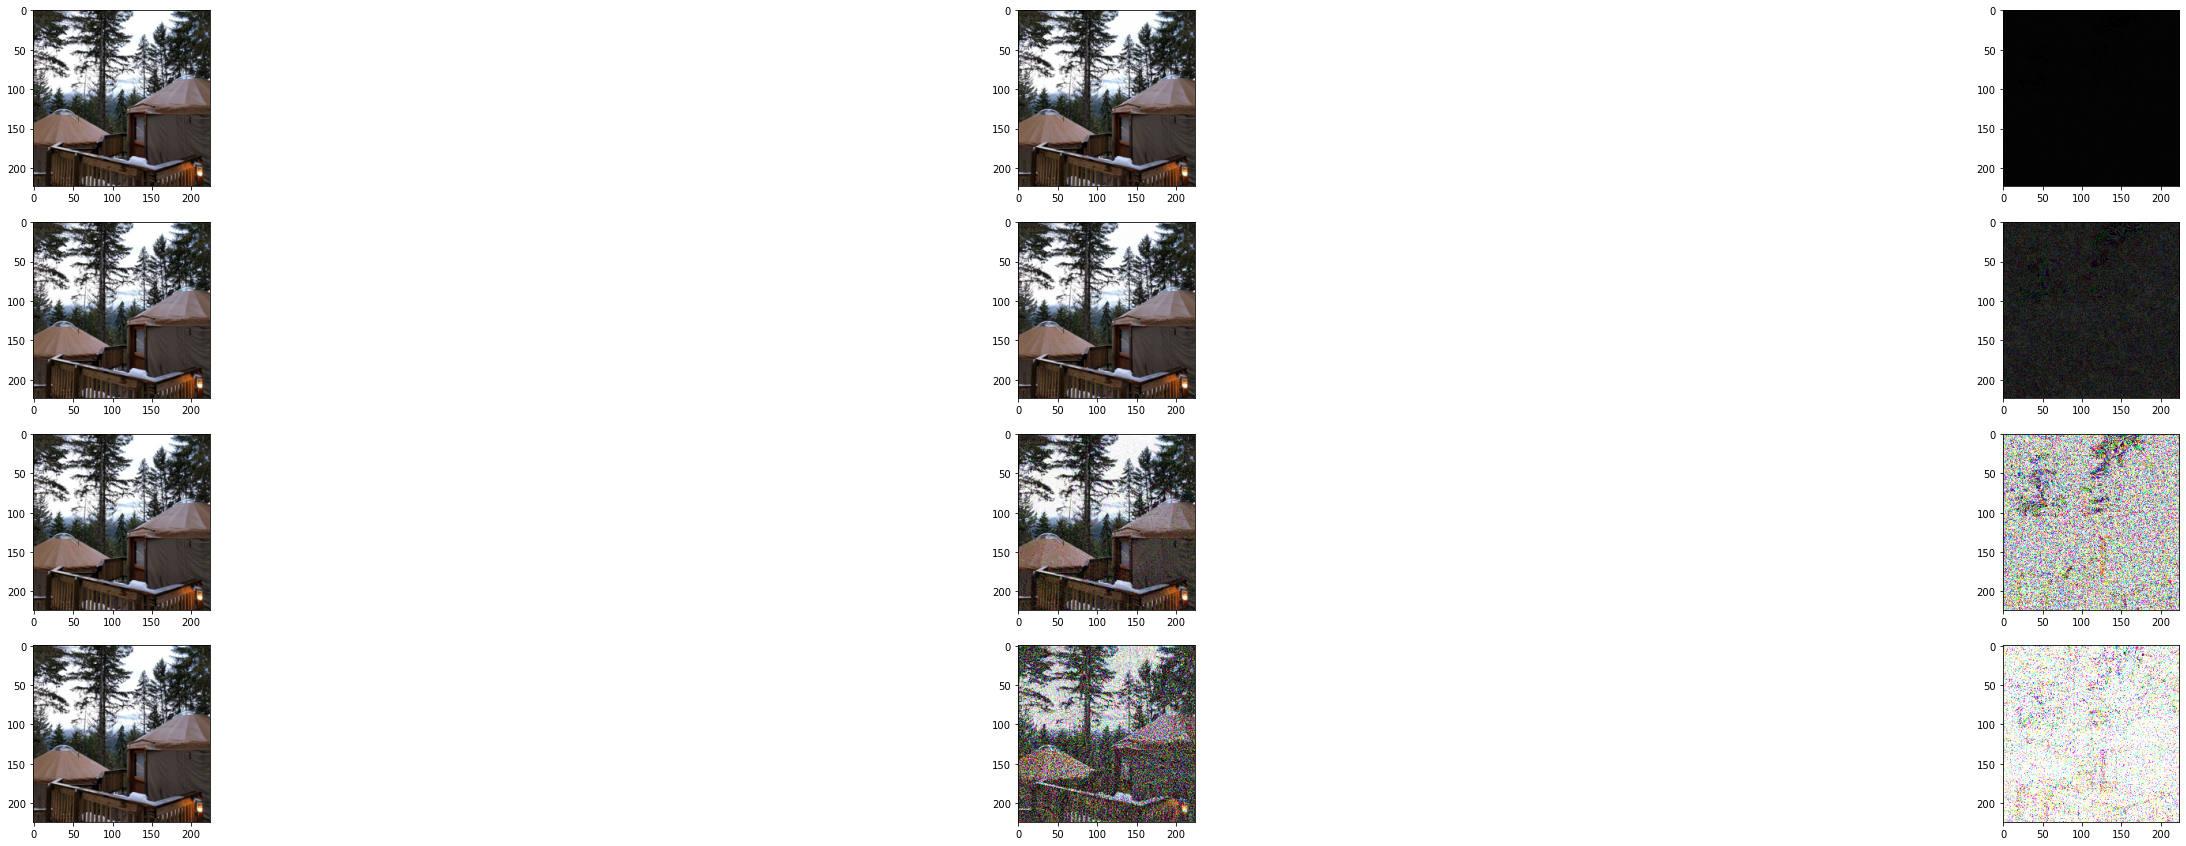

In [154]:
# for a random image, display its adversarial and difference with the original image for different values of epsilon
index = random.randint(0,len(images)-1)
image = images.numpy()
img = image[index]
lab = labels.numpy()
print("original label:",lab[index])
plt.figure(figsize=(50,50))
ligne = 0 

for advs_ in (clipped_advs):
    adv = advs_.numpy()[index]
    diff = img - adv
    plt.subplot(13, 3, 1+ligne)
    plt.imshow(img)
    plt.subplot(13, 3, 2+ligne)
    plt.imshow(adv)
    plt.subplot(13, 3, 3+ligne)
    plt.imshow(np.abs(20*diff))
    ligne += 3

Modify the previous code in order to display the new label of adversarial images.

In [177]:
#this is for helping you to display class names instead of class labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

Can you target a specific class ?

label original: yurt, new label: nematode, epsilon: 0.001
label original: yurt, new label: nematode, epsilon: 0.01
label original: yurt, new label: nematode, epsilon: 0.1
label original: yurt, new label: nematode, epsilon: 0.5


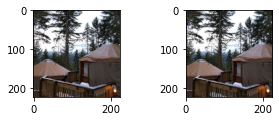

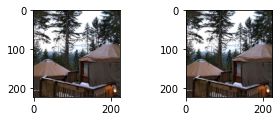

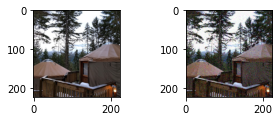

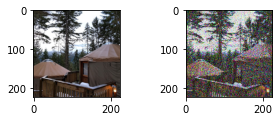

In [157]:
# for a random image, display its adversarial and difference with the original image for different values of epsilon
index = random.randint(0,len(images)-1)
image = images.numpy()
img = image[index]
lab = labels.numpy()
ligne = 0

for i, advs_ in enumerate(clipped_advs):
    plt.figure(figsize=(5,15))
    adv = advs_.numpy()[index]
    res50_label = imagenet_labels[lab[index]+1]
    pred = imagenet_labels[np.argmax(model.predict(np.array([adv])))+1]
    #print("original label:",lab[index])
    print(f"label original: {res50_label}, new label: {pred}, epsilon: {epsilons[i]}")
    plt.subplot(2*len(clipped_advs), 2, 1+ligne)
    plt.imshow(img, label="sine")
    plt.subplot(2*len(clipped_advs), 2, 2+ligne)
    plt.imshow(adv, label="sine")
    ligne += 2

<hr>

In [202]:
!pip uninstall foolbox -y
!pip install foolbox

Found existing installation: foolbox 2.4.0
Uninstalling foolbox-2.4.0:
  Successfully uninstalled foolbox-2.4.0
  Using cached foolbox-3.2.1-py3-none-any.whl (1.7 MB)
You should consider upgrading via the '/home/qlr/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
#!/usr/bin/env python3
"""
A simple example that demonstrates how to run a single attack against
a PyTorch ResNet-18 model for different epsilons and how to then report
the robust accuracy.
"""
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD


def main() -> None:
    # instantiate a model (could also be a TensorFlow or JAX model)
    model = models.resnet18(pretrained=True).eval()
    preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
    fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

    # get data and test the model
    # wrapping the tensors with ep.astensors is optional, but it allows
    # us to work with EagerPy tensors in the following
    images, labels = ep.astensors(*samples(fmodel, dataset="imagenet", batchsize=4))
    clean_acc = accuracy(fmodel, images, labels)
    print(f"clean accuracy:  {clean_acc * 100:.1f} %")

    # apply the attack
    attack = LinfPGD()
    epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.3,
        0.5,
        1.0,
    ]
    raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilons)

    # calculate and report the robust accuracy (the accuracy of the model when
    # it is attacked)
    robust_accuracy = 1 - success.float32().mean(axis=-1)
    print("robust accuracy for perturbations with")
    for eps, acc in zip(epsilons, robust_accuracy):
        print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

    # we can also manually check this
    # we will use the clipped advs instead of the raw advs, otherwise
    # we would need to check if the perturbation sizes are actually
    # within the specified epsilon bound
    print()
    print("we can also manually check this:")
    print()
    print("robust accuracy for perturbations with")
    for eps, advs_ in zip(epsilons, clipped_advs):
        acc2 = accuracy(fmodel, advs_, labels)
        print(f"  Linf norm ≤ {eps:<6}: {acc2 * 100:4.1f} %")
        print("    perturbation sizes:")
        perturbation_sizes = (advs_ - images).norms.linf(axis=(1, 2, 3)).numpy()
        print("    ", str(perturbation_sizes).replace("\n", "\n" + "    "))
        if acc2 == 0:
            break

In [2]:
main()

clean accuracy:  100.0 %
robust accuracy for perturbations with
  Linf norm ≤ 0.0   : 100.0 %
  Linf norm ≤ 0.0002: 100.0 %
  Linf norm ≤ 0.0005: 100.0 %
  Linf norm ≤ 0.0008: 25.0 %
  Linf norm ≤ 0.001 :  0.0 %
  Linf norm ≤ 0.0015:  0.0 %
  Linf norm ≤ 0.002 :  0.0 %
  Linf norm ≤ 0.003 :  0.0 %
  Linf norm ≤ 0.01  :  0.0 %
  Linf norm ≤ 0.1   :  0.0 %
  Linf norm ≤ 0.3   :  0.0 %
  Linf norm ≤ 0.5   :  0.0 %
  Linf norm ≤ 1.0   :  0.0 %

we can also manually check this:

robust accuracy for perturbations with
  Linf norm ≤ 0.0   : 100.0 %
    perturbation sizes:
     [0. 0. 0. 0.]
  Linf norm ≤ 0.0002: 100.0 %
    perturbation sizes:
     [0.0002 0.0002 0.0002 0.0002]
  Linf norm ≤ 0.0005: 100.0 %
    perturbation sizes:
     [0.00050002 0.00050002 0.00050002 0.00050002]
  Linf norm ≤ 0.0008: 25.0 %
    perturbation sizes:
     [0.00080001 0.00080001 0.00080001 0.00080001]
  Linf norm ≤ 0.001 :  0.0 %
    perturbation sizes:
     [0.001 0.001 0.001 0.001]


In [3]:
import tensorflow as tf
import eagerpy as ep
from foolbox import TensorFlowModel, accuracy, samples, Model
from foolbox.attacks import LinfPGD


def main() -> None:
    # instantiate a model (could also be a TensorFlow or JAX model)
    model = tf.keras.applications.ResNet50(weights="imagenet")
    pre = dict(flip_axis=-1, mean=[104.0, 116.0, 123.0])  # RGB to BGR
    fmodel: Model = TensorFlowModel(model, bounds=(0, 255), preprocessing=pre)
    fmodel = fmodel.transform_bounds((0, 1))

    # get data and test the model
    # wrapping the tensors with ep.astensors is optional, but it allows
    # us to work with EagerPy tensors in the following
    images, labels = ep.astensors(*samples(fmodel, dataset="imagenet", batchsize=16))
    clean_acc = accuracy(fmodel, images, labels)
    print(f"clean accuracy:  {clean_acc * 100:.1f} %")

    # apply the attack
    attack = LinfPGD()
    epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.3,
        0.5,
        1.0,
    ]
    raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilons)

    # calculate and report the robust accuracy (the accuracy of the model when
    # it is attacked)
    robust_accuracy = 1 - success.float32().mean(axis=-1)
    print("robust accuracy for perturbations with")
    for eps, acc in zip(epsilons, robust_accuracy):
        print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

    # we can also manually check this
    # we will use the clipped advs instead of the raw advs, otherwise
    # we would need to check if the perturbation sizes are actually
    # within the specified epsilon bound
    print()
    print("we can also manually check this:")
    print()
    print("robust accuracy for perturbations with")
    for eps, advs_ in zip(epsilons, clipped_advs):
        acc2 = accuracy(fmodel, advs_, labels)
        print(f"  Linf norm ≤ {eps:<6}: {acc2 * 100:4.1f} %")
        print("    perturbation sizes:")
        perturbation_sizes = (advs_ - images).norms.linf(axis=(1, 2, 3)).numpy()
        print("    ", str(perturbation_sizes).replace("\n", "\n" + "    "))
        if acc2 == 0:
            break


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
main()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
clean accuracy:  87.5 %
robust accuracy for perturbations with
  Linf norm ≤ 0.0   : 87.5 %
  Linf norm ≤ 0.0002: 87.5 %
  Linf norm ≤ 0.0005: 75.0 %
  Linf norm ≤ 0.0008: 56.2 %
  Linf norm ≤ 0.001 : 56.2 %
  Linf norm ≤ 0.0015: 31.2 %
  Linf norm ≤ 0.002 : 12.5 %
  Linf norm ≤ 0.003 :  6.2 %
  Linf norm ≤ 0.01  :  0.0 %
  Linf norm ≤ 0.1   :  0.0 %
  Linf norm ≤ 0.3   :  0.0 %
  Linf norm ≤ 0.5   :  0.0 %
  Linf norm ≤ 1.0   :  0.0 %

we can also manually check this:

robust accuracy for perturbations with
  Linf norm ≤ 0.0   : 87.5 %
    perturbation sizes:
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Linf norm ≤ 0.0002: 87.5 %
    perturbation sizes:
     [0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
     0.0002 0.0002 0.0002 0.0002 0.0002 0.0002]
  Linf norm ≤ 0.0005: 75.0 %
    perturbation sizes:
     [0.00050002 0.00050002 0.00050002 0.00050002 0.00050002 0.0005